In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
from random import randint
from sklearn.model_selection import StratifiedKFold
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_EGFRi/Expression_Mutation_CNA/Models/"
cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
em_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_EGFRi/Expression_Mutation/Predictions/"
ec_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_EGFRi/Expression_CNA/Predictions/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_EGFRi/Expression_Mutation_CNA/Predictions/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_EGFRi/Expression_Mutation_CNA/Figures/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC cell line details

os.chdir(cell_line_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC


In [5]:
# read GDSC cell line details table

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent
,TOTAL:,1001,996,968,957,990,,,,,,


In [6]:
# change directory to read GDSC expression dataset (EGFRi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (EGFRi)

GDSCE = pd.read_csv("GDSC_exprs.z.EGFRi.tsv", 
                    sep = "\t", index_col=0, decimal = ",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
683665,-0.4711563767951986,-0.1857522957766964,0.9702409548662462,-0.4081281805960821,-0.4161511169999803,-0.4384159723467665,-1.154692246005183,0.5262132484107975,-0.7950924576033422,-0.6337442716864214,...,1.283534690590172,-0.3367265464586691,-0.0039762988723447,0.7378729872604209,0.9757614264575688,0.1494417647095801,2.062294063911948,-0.8140636761719959,0.2870333828833719,0.9524265085537148
683667,0.8924335646616343,-0.2118047645974752,-1.5249963829654445,-0.5512338119420259,-0.1375180480622428,-0.5276262991742051,-0.0305604198225781,0.5226216566753464,0.4877783097403741,0.2252883573642275,...,-0.0156845434045267,-0.1612071417519457,1.2033249282722671,2.7714836839186687,-0.3165072496327769,-0.8849200030571541,-0.5104734344593952,0.2984361940989172,-0.4349407065496763,0.4747633022523675
684057,0.6510004960254864,1.6578876382433665,-0.4977106390881842,-0.1212172092933644,-0.398455281697677,-0.2804901106672752,0.6455898116420014,0.215833091774836,-0.1723595788875009,-0.2170870770552223,...,-0.024863133395904,0.4073439017665206,-0.4440356638831038,0.8630347078663075,1.4486171428489227,-1.4777214830771732,0.5220400480464272,0.6441211958947753,0.9057518606131394,0.3018783753479829


In [8]:
# change directory to read GDSC mutation dataset (EGFRi)

os.chdir(dataset_dir + "/mutations/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations


In [9]:
# read GDSC mutation dataset (EGFRi)

GDSCM = pd.read_csv("GDSC_mutations.EGFRi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCM.drop_duplicates(keep='last')
GDSCM = pd.DataFrame.transpose(GDSCM)
GDSCM = GDSCM.loc[:, ~GDSCM.columns.duplicated()]

GDSCM.head()

,143872,728577,2,2050,10243,79365,256006,4609,118788,113675,...,26517,28972,53917,283507,514,339210,64981,7335,5739,83442
683665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
683667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# change directory to read GDSC CNA dataset (EGFRi)

os.chdir(dataset_dir + "/CNA/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA


In [11]:
# read GDSC CNA dataset (EGFRi)

GDSCC = pd.read_csv("GDSC_CNA.EGFRi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCC.drop_duplicates(keep='last')
GDSCC = pd.DataFrame.transpose(GDSCC)
GDSCC = GDSCC.loc[:, ~GDSCC.columns.duplicated()]

In [12]:
# change directory to read GDSC response dataset (EGFRi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [13]:
# read GDSC response dataset (EGFRi)

GDSCR = pd.read_csv("GDSC_response.EGFRi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
filter = GDSCR["drug"] != "Afatinib (rescreen)"
GDSCR = GDSCR.loc[filter, ]
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,1.49001536063508,Afatinib,1,1,1
683665,0,6.29444657935625,Cetuximab,1,1,1
683665,0,-1.50094791622811,CUDC-101,1,1,1
683665,1,-0.966773876200563,EKB-569,1,1,1
683665,0,2.43658649242319,Erlotinib,1,1,1


In [14]:
# print count of cell lines for each drug (EGFRi)

GDSCR["drug"].value_counts()

drug
EKB-569       770
CUDC-101      754
Afatinib      738
Gefitinib     734
Cetuximab     725
HG-5-88-01    422
Lapatinib     371
Erlotinib     362
Name: count, dtype: int64

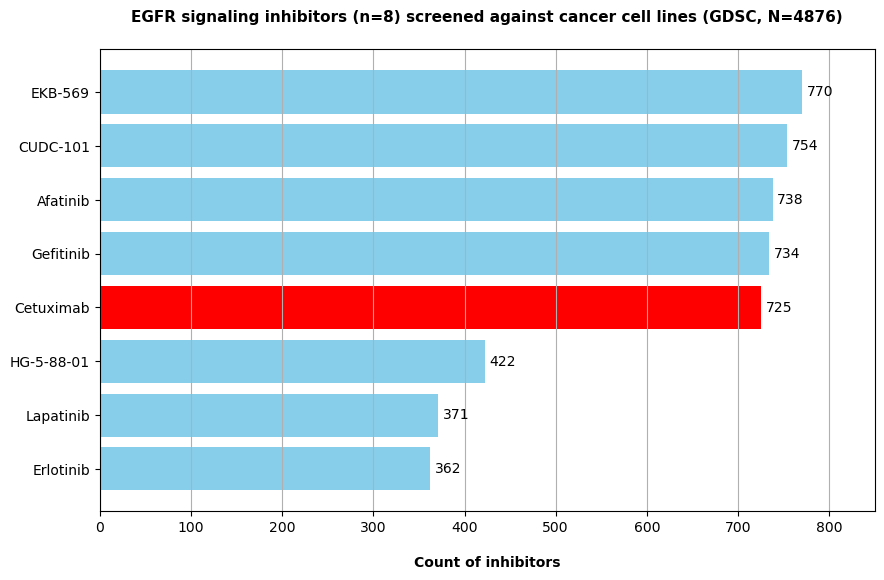

In [15]:
# plot EGFR signaling inhibitors with their counts

gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(drug_names, drug_values, color='skyblue')

for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')
    
bars = []

for name, value in zip(drug_names, drug_values):
    if name == "Cetuximab":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))
plt.xlabel('Count of inhibitors', fontweight='bold', labelpad=15)
plt.title(f'EGFR signaling inhibitors (n={len(drug_names)}) screened against cancer cell lines (GDSC, N={sum(drug_values)})',
          fontweight='bold',
          fontsize=11,
          pad=20)
plt.xlim(0, 850)  
plt.grid(axis='x')
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + 'EGFR Signaling Inhibitors with Their Counts (GDSC, Cetuximab).png', format='png', bbox_inches='tight')

plt.show()

In [16]:
# change directory to read TCGA expression dataset homogenized with GDSC expression dataset (Cetuximab)

os.chdir(dataset_dir + "exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [17]:
# read TCGA expression dataset homogenized with GDSC expression dataset (Cetuximab)

TCGAEcetuximab = pd.read_csv("TCGA_exprs.Cetuximab.eb_with.GDSC_exprs.Cetuximab.tsv",
                   sep = "\t", index_col=0, decimal = ",")
TCGAEcetuximab = pd.DataFrame.transpose(TCGAEcetuximab)
TCGAEcetuximab.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100188893,100190940,100190949,100191040,100192386,100268168,100271715,100287718,100288778,100289635
TCGA-BA-A4IG-01A,3.53364972782538,2.63169744477874,6.46913538384915,3.11954321356217,1.78425710174861,4.78953909500701,8.06446753523746,3.04479803527151,9.18974247446462,2.91775104542515,...,9.88694622925868,3.1254895591217,0,3.5074580817852,3.01824927947277,2.84422970206547,3.5035589781396,3.06737618948643,4.01010719689955,4.66295551081748
TCGA-CN-4731-01A,4.12585378817146,2.1506582678597,6.44489273685529,3.21409376420109,3.15286503399873,3.28492483066951,8.22062958425597,2.67285528315238,8.51873835886811,5.1735664410497,...,9.26858559890324,3.08733295866026,0,3.30585011523952,3.3487497141691,2.6930439585389,2.45792584512192,2.99299508958328,3.94714478968898,4.17054508896713
TCGA-CN-A49C-01A,4.37925369978313,3.43283585192836,6.59346803138021,3.11954321356217,3.31289809486857,3.10283527665291,8.2759744669096,2.74770994492163,8.98377132955025,3.96878580867183,...,9.71555609970402,3.0546486734275,0,3.67110924364761,3.04644627367641,2.61249547417883,3.00945260505516,3.06200290033863,5.05997145230091,4.13533467313432


In [18]:
# change directory to read TCGA mutation dataset (Cetuximab)

os.chdir(dataset_dir + "mutations")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations'

In [19]:
# read TCGA mutation dataset (Cetuximab)

TCGAMcetuximab = pd.read_csv("TCGA_mutations.Cetuximab.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGAMcetuximab.drop_duplicates(keep='last')
TCGAMcetuximab = pd.DataFrame.transpose(TCGAMcetuximab)
TCGAMcetuximab = TCGAMcetuximab.loc[:, ~TCGAMcetuximab.columns.duplicated()]

TCGAMcetuximab.head(3)

,27136,84993,56834,10256,6672,253461,90134,162333,345630,10278,...,374395,23173,646498,23016,10888,8347,29901,9445,766,2944
TCGA-BA-A4IG-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-CN-4731-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-CN-A49C-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# change directory to read TCGA CNA dataset (Cetuximab)

os.chdir(dataset_dir + "CNA")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA'

In [21]:
# read TCGA CNA dataset (Cetuximab)

TCGACcetuximab = pd.read_csv("TCGA_CNA.Cetuximab.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGACcetuximab.drop_duplicates(keep='last')
TCGACcetuximab = pd.DataFrame.transpose(TCGACcetuximab)
TCGACcetuximab = TCGACcetuximab.loc[:, ~TCGACcetuximab.columns.duplicated()]

TCGACcetuximab.head(3)

,2,3,9,10,11,12,13,24,30,34,...,100652795,100652800,2104,9534,359762,730087,100101266,100419711,100421702,100505851
TCGA-BA-A4IG-01A,0.3326,0.3326,0.0,0.0,0.0,0.0,0.504,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-CN-4731-01A,0.0,0.0,0.3089,0.3089,0.3089,0.0,0.4264,-0.5391,-0.5456,-0.5391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-CN-A49C-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.763,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# variance threshold for GDSC Expression dataset (EGFRi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [23]:
# fill NA values and binarize GDSC mutation and CNA datasets (EGFRi)

GDSCM = GDSCM.fillna(0)
GDSCM[GDSCM != 0.0] = 1
GDSCC = GDSCC.fillna(0)
GDSCC[GDSCC != 0.0] = 1

In [24]:
# select shared genes between GDSC and TCGA expression, mutation, and CNA datasets 

ls = GDSCE.columns.intersection(GDSCM.columns)
ls = ls.intersection(GDSCC.columns)
ls = ls.intersection(TCGAEcetuximab.columns)
ls = ls.intersection(TCGAMcetuximab.columns)
ls = ls.intersection(TCGACcetuximab.columns)

ls = pd.unique(ls)

print(f"GDSC and TCGA# of common genes: {ls.shape[0]}")

GDSC and TCGA# of common genes: 13759


In [25]:
# select shared samples between GDSC expression, mutation, CNA, and response datasets (EGFRi)

ls2 = GDSCE.index.intersection(GDSCM.index)
ls2 = ls2.intersection(GDSCC.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 800


In [26]:
# subset shared genes and samples in GDSC expression, mutation, CNA, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCM = GDSCM.loc[ls2, ls]
GDSCC = GDSCC.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCM.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCC.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

GDSC # of common samples and genes (Expression): (800, 13759)
GDSC # of common samples and genes (Mutation): (800, 13759)
GDSC # of common samples and genes (CNA): (800, 13759)
GDSC # of samples (Response): 4876


In [27]:
# select shared samples between TCGA expression, mutation, and CNA datasets (Cetuximab) 

ls3 = TCGAEcetuximab.index.intersection(TCGAMcetuximab.index)
ls3 = ls3.intersection(TCGACcetuximab.index)

print(f"TCGA # of common samples (Cetuximab): {ls3.shape[0]}")

TCGA # of common samples (Cetuximab): 9


In [28]:
# select shared genes and samples between TCGA expression, mutation, and CNA datasets (Cetuximab)

TCGAEcetuximab = TCGAEcetuximab.loc[ls3, ls]
TCGAMcetuximab = TCGAMcetuximab.loc[ls3, ls]
TCGACcetuximab = TCGACcetuximab.loc[ls3, ls]

print(f"TCGA # of common samples and genes for Expression (Cetuximab): {TCGAEcetuximab.shape}")
print(f"TCGA # of common samples and genes for Mutation (Cetuximab): {TCGAMcetuximab.shape}")
print(f"TCGA # of common samples and genes for CNA (Cetuximab): {TCGACcetuximab.shape}\n")

TCGA # of common samples and genes for Expression (Cetuximab): (9, 13759)
TCGA # of common samples and genes for Mutation (Cetuximab): (9, 13759)
TCGA # of common samples and genes for CNA (Cetuximab): (9, 13759)



In [29]:
# change directory to read DEGs (EGFRi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi


In [30]:
# read DEGs (EGFRi)

DEGs_filtered_data = pd.read_excel("EGFRi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among EGFR signaling inhibitors\n")

DEGs_filtered_data.head()

There are 1028 DEGs (p-adjusted < 0.05 and |logFC| > 1) among EGFR signaling inhibitors



,Gene Symbol,Frequency
0,MYOF,9
1,TM4SF1,8
2,KRT18,8
3,WWC1,8
4,CAV1,8


In [31]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id = pd.unique(DEGs_entrez_id.dropna())
DEGs_entrez_id = pd.Series(DEGs_entrez_id)

result = mg.query("SLC22A18", species="human", scopes="symbol", fields="entrezgene")
DEGs_entrez_id = pd.concat([DEGs_entrez_id, pd.Series(str(result["hits"][1]["entrezgene"]))], ignore_index=True)

DEGs_entrez_id.shape[0]

2 input query terms found dup hits:	[('CLECL1P', 2), ('CAST', 2)]
1 input query terms found no hit:	['SLC22A18']


1028

In [32]:
# assign GDSC data to new variables

exprs_z = GDSCE
mut = GDSCM
cna = GDSCC
responses = GDSCR

In [33]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,1.49001536063508,Afatinib,1,1,1
683665,0,6.29444657935625,Cetuximab,1,1,1
683665,0,-1.50094791622811,CUDC-101,1,1,1


In [34]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'Afatinib',
 'CUDC-101',
 'Cetuximab',
 'EKB-569',
 'Erlotinib',
 'Gefitinib',
 'HG-5-88-01',
 'Lapatinib'}

In [35]:
# convert Entrez gene IDs to integer

responses.index = responses.index.astype(int)
responses.index

Index([683665, 683665, 683665, 683665, 683665, 683665, 683665, 683665, 683667,
       683667,
       ...
       910930, 910941, 910941, 924248, 924248, 924248, 906849, 906849, 949162,
       949162],
      dtype='int64', length=4876)

In [36]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
#dat.head()

GDSC\nTissue descriptor 1
lung_NSCLC           509
leukemia             472
urogenital_system    452
lymphoma             428
aero_dig_tract       348
nervous_system       320
lung_SCLC            307
skin                 287
breast               257
large_intestine      242
digestive_system     230
bone                 228
neuroblastoma        189
pancreas             132
kidney               119
myeloma               99
soft_tissue           96
lung                  84
thyroid               77
Name: count, dtype: int64

In [37]:
# get tissue descriptors

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    313
lung_small_cell_carcinoma    307
glioma                       296
melanoma                     267
breast                       257
Name: count, dtype: int64

In [38]:
# get count of total HNSC tissues

tissues = dat["GDSC\nTissue\ndescriptor 2"].value_counts()
count_selected_tissues = tissues["head and neck"].astype(int) 
count_selected_tissues

208

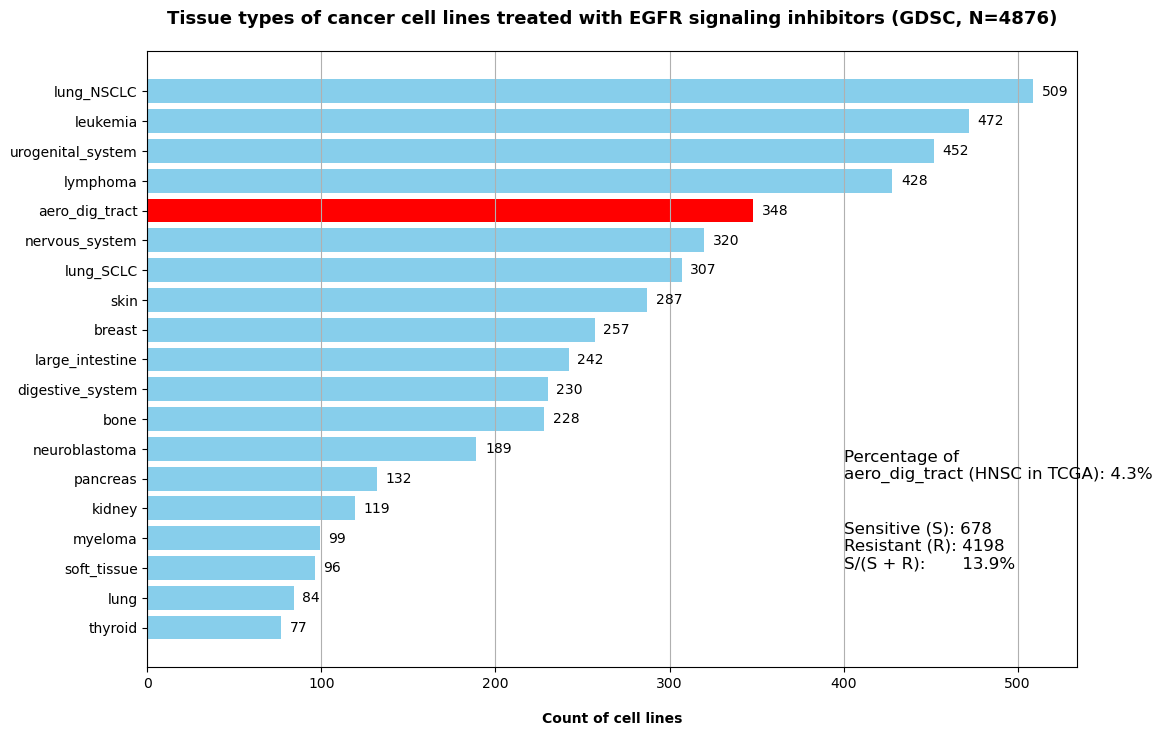

In [39]:
# plot tissue types of cancer cell lines treated with EGFR signaling inhibitors

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with EGFR signaling inhibitors (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "aero_dig_tract":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(400, 13, 
         f'Percentage of \naero_dig_tract (HNSC in TCGA): {round(count_selected_tissues/sum(tissue_counts) * 100, 1)}%', 
         fontsize=12, 
         color='black')

plt.text(400, 16, 
         f'Sensitive (S): {dat[["response"]].value_counts()[1]} \nResistant (R): {dat[["response"]].value_counts()[0]} \nS/(S + R):       {round(dat[["response"]].value_counts()[1]/(sum(dat[["response"]].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')


plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with EGFR signaling inhibitors (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [40]:
# list count of cell lines as to tissues treated with cetuximab

filter = (dat["drug"] == "Cetuximab")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
lung_NSCLC           87
urogenital_system    76
leukemia             66
lymphoma             56
aero_dig_tract       56
nervous_system       47
skin                 44
breast               41
lung_SCLC            39
digestive_system     37
bone                 34
large_intestine      33
pancreas             20
kidney               19
neuroblastoma        19
soft_tissue          16
myeloma              13
lung                 11
thyroid              11
Name: count, dtype: int64

In [41]:
# list count of cell lines as to tissues treated with cetuximab

tissues_drugs = dat[["GDSC\nTissue descriptor 1","GDSC\nTissue\ndescriptor 2","drug"]]

filter = (tissues_drugs["drug"] == "Cetuximab")
tissues_drug = tissues_drugs.loc[filter,"GDSC\nTissue\ndescriptor 2"].value_counts()

tissues_drug.head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    54
glioma                       44
breast                       41
melanoma                     41
lung_small_cell_carcinoma    39
Name: count, dtype: int64

In [42]:
# count of HNSC cell lines treated with paclitaxel

count_selected_tissues = tissues_drug["head and neck"].astype(int) 
count_selected_tissues

35

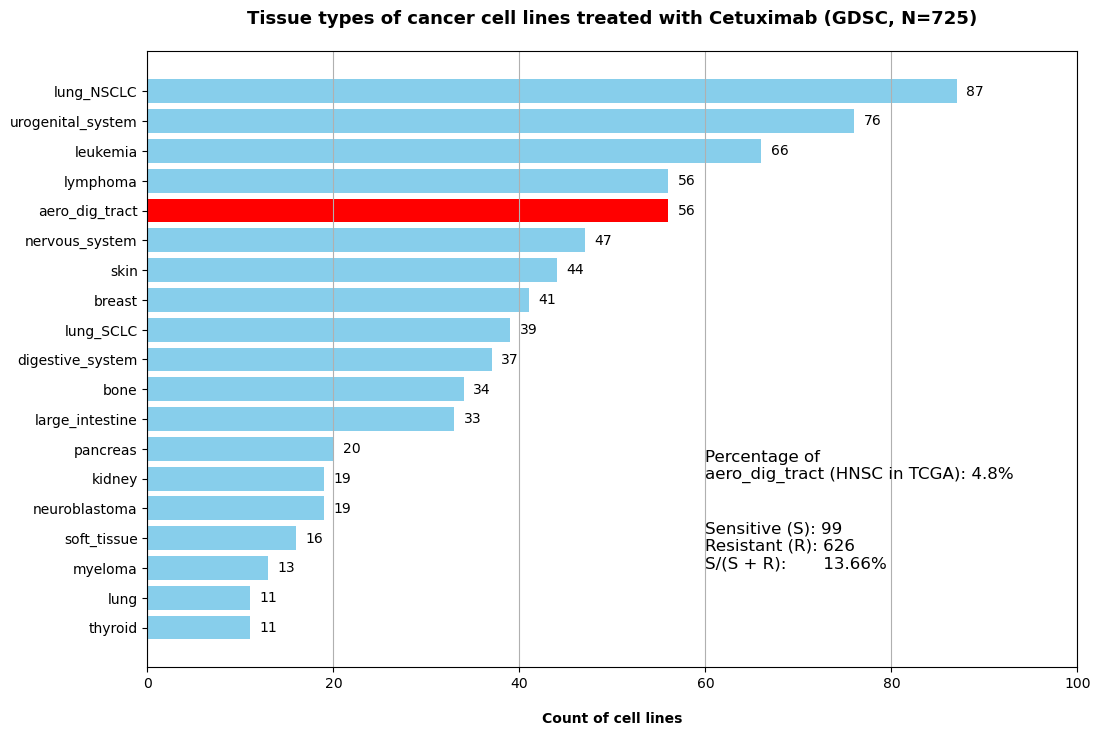

In [43]:
# plot tissue types of cancer cell lines treated with cetuximab

gdsc_tissue_counts =  tissues_drugs.loc[filter, 'GDSC\nTissue descriptor 1'].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with Cetuximab (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.xlim(0, 100)
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 1, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "aero_dig_tract":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(60, 13, 
         f'Percentage of \naero_dig_tract (HNSC in TCGA): {round(count_selected_tissues/sum(tissue_counts) * 100, 1)}%', 
         fontsize=12, 
         color='black')

plt.text(60, 16, 
         f'Sensitive (S): {dat.loc[dat["drug"] == "Cetuximab", "response"].value_counts()[1]} \nResistant (R): {dat.loc[dat["drug"] == "Cetuximab", "response"].value_counts()[0]} \nS/(S + R):       {round(dat.loc[dat["drug"] == "Cetuximab", "response"].value_counts()[1]/(sum(dat.loc[dat["drug"] == "Cetuximab", "response"].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')

plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with Cetuximab (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [44]:
# convert Entrez gene IDs to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683667', '683667',
       ...
       '910930', '910941', '910941', '924248', '924248', '924248', '906849',
       '906849', '949162', '949162'],
      dtype='object', length=4876)

In [45]:
# filter GDSC expression, mutation, and CNA datasets (EGFRi) as to drugs
# subset selected DEGs

expression_zscores = []
CNA = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    c = cna.loc[samples, :]
    m = mut.loc[samples, :]

    expression_zscores.append(e_z)
    CNA.append(c)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCCv2 = pd.concat(CNA, axis=0)
GDSCRv2 = responses

ls4 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls5 = GDSCEv2.index.intersection(GDSCMv2.index)
ls5 = ls5.intersection(GDSCCv2.index)

GDSCEv2 = GDSCEv2.loc[ls5, ls4]
GDSCMv2 = GDSCMv2.loc[ls5, ls4]
GDSCCv2 = GDSCCv2.loc[ls5, ls4]
GDSCRv2 = GDSCRv2.loc[ls5, :]

TCGAEcetuximab = TCGAEcetuximab.loc[:,ls4]
TCGAMcetuximab = TCGAMcetuximab.loc[:,ls4]
TCGACcetuximab = TCGACcetuximab.loc[:,ls4]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCCv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"TCGA # of common samples and genes for Cetuximab (Expression): {TCGAEcetuximab.shape}")
print(f"TCGA # of common samples and genes for Cetuximab (Mutation): {TCGAMcetuximab.shape}")
print(f"TCGA # of common samples and genes for Cetuximab (CNA): {TCGACcetuximab.shape}\n")

GDSC # of common samples and genes (Expression): (4876, 791)
GDSC # of common samples and genes (Mutation): (4876, 791)
GDSC # of common samples and genes (CNA): (4876, 791)
GDSC # of common samples (Response): 4876

TCGA # of common samples and genes for Cetuximab (Expression): (9, 791)
TCGA # of common samples and genes for Cetuximab (Mutation): (9, 791)
TCGA # of common samples and genes for Cetuximab (CNA): (9, 791)



In [46]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 0 ... 0 0 0]


In [47]:
# change directory to read TCGA response dataset (Cetuximab)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [48]:
# read TCGA response dataset (Cetuximab)

TCGARcetuximab = pd.read_csv("TCGA_response.Cetuximab.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
TCGARcetuximab.dropna(inplace=True)
TCGARcetuximab.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
TCGARcetuximab["response"] = TCGARcetuximab.loc[:, "response"].apply(lambda x: d[x])
Ytscetuximab = TCGARcetuximab["response"].values    

print(f"There are {Ytscetuximab.shape[0]} samples with response data in the TCGA (Cetuximab)\n")
Ytscetuximab

There are 9 samples with response data in the TCGA (Cetuximab)



array([1, 0, 1, 1, 1, 1, 0, 0, 1])

In [49]:
# TCGA cohort table with TCGA response dataset (Cetuximab)

dat_tcga = TCGARcetuximab["cohort"]

dat_tcga.value_counts()

cohort
HNSC    9
Name: count, dtype: int64

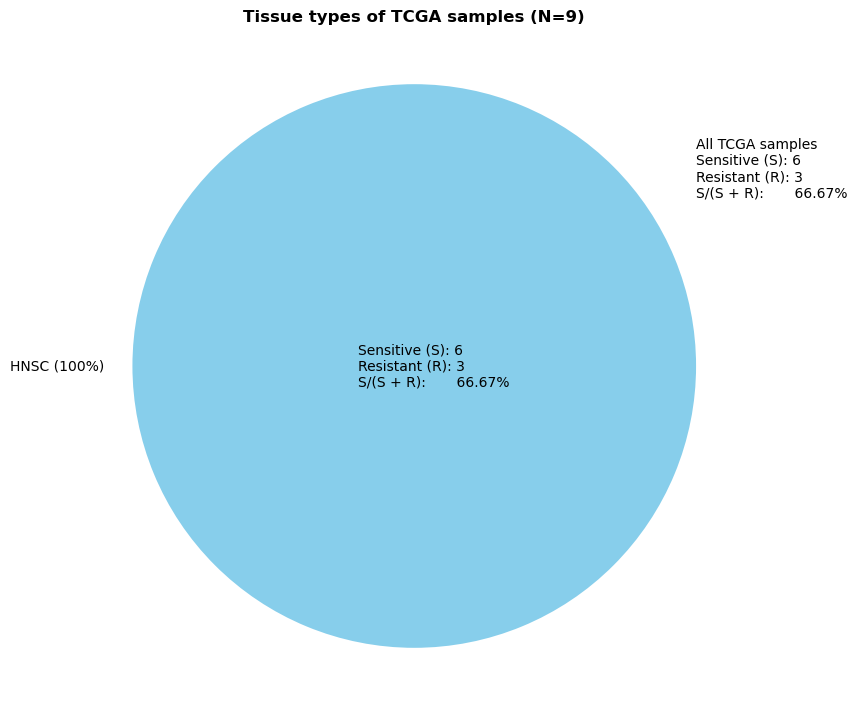

In [50]:
# plot tissue types of TCGA samples 

labels = list(dat_tcga.value_counts().index)
sizes = list(dat_tcga.value_counts())
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_with_percentages, startangle=0, colors=['skyblue', 'lightgreen', 'salmon', 'orange'])
plt.title(f'Tissue types of TCGA samples (N={total})', fontweight = "bold")
plt.subplots_adjust(top=0.95) 
plt.axis('equal')  

plt.text(-0.2, 0, 
         f'Sensitive (S): {TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]} \nResistant (R): {TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]/(sum(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.text(1, 0.7, 
         f'All TCGA samples\nSensitive (S): {TCGARcetuximab["response"].value_counts()[1]} \nResistant (R): {TCGARcetuximab["response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARcetuximab["response"].value_counts()[1]/(sum(TCGARcetuximab["response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of TCGA samples (5-cetorouracil).png', format='png', bbox_inches='tight')

plt.show()

In [51]:
# filter HNSC cohort samples (Cetuximab)

filter = (TCGARcetuximab["cohort"] == "HNSC")
tcga_hnsc_samples = dat_tcga.loc[filter,].index
tcga_hnsc_samples

Index(['TCGA-BA-A4IG-01A', 'TCGA-CN-4731-01A', 'TCGA-CN-A49C-01A',
       'TCGA-CN-A6V1-01A', 'TCGA-CR-7404-01A', 'TCGA-DQ-7596-01A',
       'TCGA-HD-8224-01A', 'TCGA-KU-A6H8-01A', 'TCGA-RS-A6TO-01A'],
      dtype='object', name='sample')

In [52]:
# filter responses of HNSC cohort samples (Cetuximab)

Ytscetuximab_hnsc = TCGARcetuximab.loc[tcga_hnsc_samples,"response"].values
Ytscetuximab_hnsc

array([1, 0, 1, 1, 1, 1, 0, 0, 1])

In [53]:
# count of sensitive and resistance HNSC samples (Cetuximab)

TCGARcetuximab.loc[tcga_hnsc_samples,"response"].value_counts()

response
1    6
0    3
Name: count, dtype: int64

In [54]:
# define maximum iteration

max_iter = 50

In [55]:
# assign number of neurons and dropout rates found for layers from the saved models

hdm1 = 1024
hdm2 = 128
hdm3 = 128
rate1 = 0.7
rate2 = 0.4
rate3 = 0.3
rate4 = 0.7

In [56]:
# load pre-trained models and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEcetuximab = scalerGDSC.transform(TCGAEcetuximab.values) 
X_testEcetuximab_hnsc = scalerGDSC.transform(TCGAEcetuximab.loc[tcga_hnsc_samples,].values) 

X_trainM = np.nan_to_num(GDSCMv2.values)
X_testMcetuximab = np.nan_to_num(TCGAMcetuximab.values.astype(np.float32))
X_testMcetuximab_hnsc = np.nan_to_num(TCGAMcetuximab.loc[tcga_hnsc_samples,].values.astype(np.float32))

X_trainC = np.nan_to_num(GDSCCv2.values)
X_testCcetuximab = np.nan_to_num(TCGACcetuximab.values.astype(np.float32))
X_testCcetuximab_hnsc = np.nan_to_num(TCGACcetuximab.loc[tcga_hnsc_samples,].values.astype(np.float32))

TX_testEcetuximab = torch.FloatTensor(X_testEcetuximab)
TX_testEcetuximab_hnsc = torch.FloatTensor(X_testEcetuximab_hnsc)

TX_testMcetuximab = torch.FloatTensor(X_testMcetuximab.astype(np.float32))
TX_testMcetuximab_hnsc = torch.FloatTensor(X_testMcetuximab_hnsc.astype(np.float32))

TX_testCcetuximab = torch.FloatTensor(X_testCcetuximab.astype(np.float32))
TX_testCcetuximab_hnsc = torch.FloatTensor(X_testCcetuximab_hnsc.astype(np.float32))

ty_testEcetuximab = torch.FloatTensor(Ytscetuximab.astype(int))
ty_testEcetuximab_hnsc = torch.FloatTensor(Ytscetuximab_hnsc.astype(int))

n_sampE, IE_dim = X_trainE.shape
n_sampM, IM_dim = X_trainM.shape
n_sampC, IC_dim = X_trainC.shape

h_dim1 = hdm1
h_dim2 = hdm2
h_dim3 = hdm3        
Z_in = h_dim1 + h_dim2 + h_dim3

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEM(nn.Module):
    def __init__(self):
        super(AEM, self).__init__()
        self.EnM = torch.nn.Sequential(
            nn.Linear(IM_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnM(x)
        return output       

class AEC(nn.Module):
    def __init__(self):
        super(AEC, self).__init__()
        self.EnC = torch.nn.Sequential(
            nn.Linear(IC_dim, h_dim3),
            nn.BatchNorm1d(h_dim3),
            nn.ReLU(),
            nn.Dropout(rate3))
    def forward(self, x):
        output = self.EnC(x)
        return output 
        
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate4),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA.pt")
AutoencoderM = torch.load(models_dir + "Mut_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA.pt")
AutoencoderC = torch.load(models_dir + "CNA_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA.pt")

Clas = torch.load(models_dir + "Class_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA.pt")

AutoencoderE.eval()
AutoencoderM.eval()
AutoencoderC.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZMX = AutoencoderM(torch.FloatTensor(X_trainM))
ZCX = AutoencoderC(torch.FloatTensor(X_trainC))
ZTX = torch.cat((ZEX, ZMX, ZCX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUC (TCGA_EGFRi): {round(AUCT,2)}")
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUCPR (TCGA_EGFRi): {round(AUCTaucpr,2)}\n")

ZETcetuximab = AutoencoderE(TX_testEcetuximab)
ZMTcetuximab = AutoencoderM(TX_testMcetuximab)
ZCTcetuximab = AutoencoderC(TX_testCcetuximab)
ZTTcetuximab = torch.cat((ZETcetuximab, ZMTcetuximab, ZCTcetuximab), 1)
ZTTcetuximab = F.normalize(ZTTcetuximab, p=2, dim=0)
PredTcetuximab = Clas(ZTTcetuximab)
AUCTcetuximab = roc_auc_score(Ytscetuximab.astype(int), PredTcetuximab.detach().numpy())
#print(f"TCGA - Test AUC (Cetuximab): {round(AUCTcetuximab,2)}")
AUCTcetuximab_aucpr = average_precision_score(Ytscetuximab.astype(int), PredTcetuximab.detach().numpy())
#print(f"TCGA - Test AUCPR (Cetuximab): {round(AUCTcetuximab_aucpr,2)}\n")

ZETcetuximab = AutoencoderE(TX_testEcetuximab)
ZMTcetuximab = AutoencoderM(TX_testMcetuximab)
ZCTcetuximab = AutoencoderC(TX_testCcetuximab)
ZTTcetuximab = torch.cat((ZETcetuximab, ZMTcetuximab, ZCTcetuximab), 1)
ZTTcetuximab = F.normalize(ZTTcetuximab, p=2, dim=0)
PredTcetuximab = Clas(ZTTcetuximab)
AUCTcetuximab_hnsc = roc_auc_score(Ytscetuximab.astype(int), PredTcetuximab.detach().numpy())
#print(f"TCGA - Test AUC (Cetuximab, HNSC): {round(AUCTcetuximab,2)}")
AUCTcetuximab_aucp_hnsc = average_precision_score(Ytscetuximab.astype(int), PredTcetuximab.detach().numpy())
#print(f"TCGA - Test AUCPR (Cetuximab, HNSC): {round(AUCTcetuximab_aucpr,2)}\n")

ZETcetuximab_hnsc = AutoencoderE(TX_testEcetuximab_hnsc)
ZMTcetuximab_hnsc = AutoencoderM(TX_testMcetuximab_hnsc)
ZCTcetuximab_hnsc = AutoencoderC(TX_testCcetuximab_hnsc)
ZTTcetuximab_hnsc = torch.cat((ZETcetuximab_hnsc, ZMTcetuximab_hnsc, ZCTcetuximab_hnsc), 1)
ZTTcetuximab_hnsc = F.normalize(ZTTcetuximab_hnsc, p=2, dim=0)
PredTcetuximab_hnsc = Clas(ZTTcetuximab_hnsc)
AUCTcetuximab_hnsc = roc_auc_score(Ytscetuximab_hnsc.astype(int), PredTcetuximab_hnsc.detach().numpy())
#print(f"TCGA - Test AUC (Cetuximab, HNSC): {round(AUCTcetuximab_hnsc,2)}")
AUCTcetuximab_hnsc_aucpr = average_precision_score(Ytscetuximab_hnsc.astype(int), PredTcetuximab_hnsc.detach().numpy())
#print(f"TCGA - Test AUCPR (Cetuximab, HNSC): {round(AUCTcetuximab_hnsc_aucpr,2)}\n")

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTcetuximab_finetuned = dict()
AUCTcetuximab_hnsc_finetuned = dict()
AUCTcetuximab_aucpr_finetuned = dict()
AUCTcetuximab_hnsc_aucpr_finetuned = dict()
for iter in range(max_iter):
   iter += 1  

   AutoencoderE_finetuned = torch.load(models_dir + f"Finetuned_Models/Exprs_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_{iter}.pt")
   AutoencoderM_finetuned = torch.load(models_dir + f"Finetuned_Models/Mut_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_{iter}.pt")
   AutoencoderC_finetuned = torch.load(models_dir + f"Finetuned_Models/CNA_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_{iter}.pt")
   Clas_finetuned = torch.load(models_dir + f"Finetuned_Models/Class_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_{iter}.pt")
   
   AutoencoderE_finetuned.eval()
   AutoencoderM_finetuned.eval()
   AutoencoderC_finetuned.eval()
   Clas_finetuned.eval()
      
   ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
   ZMX = AutoencoderM_finetuned(torch.FloatTensor(X_trainM))
   ZCX = AutoencoderC_finetuned(torch.FloatTensor(X_trainC))
   ZTX = torch.cat((ZEX, ZMX, ZCX), 1)
   ZTX = F.normalize(ZTX, p=2, dim=0)
   PredX = Clas_finetuned(ZTX)
   AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
   AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
   ZETcetuximab = AutoencoderE_finetuned(TX_testEcetuximab)
   ZMTcetuximab = AutoencoderM_finetuned(TX_testMcetuximab)
   ZCTcetuximab = AutoencoderC_finetuned(TX_testCcetuximab)
   ZTTcetuximab = torch.cat((ZETcetuximab, ZMTcetuximab, ZCTcetuximab), 1)
   ZTTcetuximab = F.normalize(ZTTcetuximab, p=2, dim=0)
   PredTcetuximab = Clas_finetuned(ZTTcetuximab)
   AUCTcetuximab_finetuned[iter] = roc_auc_score(Ytscetuximab.astype(int), PredTcetuximab.detach().numpy())
   AUCTcetuximab_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab.astype(int), PredTcetuximab.detach().numpy())

   ZETcetuximab_hnsc = AutoencoderE_finetuned(TX_testEcetuximab_hnsc)
   ZMTcetuximab_hnsc = AutoencoderM_finetuned(TX_testMcetuximab_hnsc)
   ZCTcetuximab_hnsc = AutoencoderC_finetuned(TX_testCcetuximab_hnsc)
   ZTTcetuximab_hnsc = torch.cat((ZETcetuximab_hnsc, ZMTcetuximab_hnsc, ZCTcetuximab_hnsc), 1)
   ZTTcetuximab_hnsc = F.normalize(ZTTcetuximab_hnsc, p=2, dim=0)
   PredTcetuximab_hnsc = Clas_finetuned(ZTTcetuximab_hnsc)
   AUCTcetuximab_hnsc_finetuned[iter] = roc_auc_score(Ytscetuximab_hnsc.astype(int), PredTcetuximab_hnsc.detach().numpy())
   AUCTcetuximab_hnsc_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab_hnsc.astype(int), PredTcetuximab_hnsc.detach().numpy())

max_key = max(AUCTcetuximab_aucpr_finetuned, key=AUCTcetuximab_aucpr_finetuned.get)
max_key_hnsc = max(AUCTcetuximab_hnsc_aucpr_finetuned, key=AUCTcetuximab_hnsc_aucpr_finetuned.get)

print(f"GDSC - Training AUC (EGFRi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (EGFRi): {round(AUCTaucpr,2)}")
print(f"TCGA - Test AUC (Cetuximab): {round(AUCTcetuximab,2)}")
print(f"TCGA - Test AUCPR (Cetuximab): {round(AUCTcetuximab_aucpr,2)}")
print(f"TCGA - Test AUC (Cetuximab, HNSC): {round(AUCTcetuximab_hnsc,2)}")
print(f"TCGA - Test AUCPR (Cetuximab, HNSC): {round(AUCTcetuximab_hnsc_aucpr,2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key],2)}")
print(f"TCGA - Test AUC (Cetuximab, Finetuned): {round(AUCTcetuximab_finetuned[max_key],2)}")
print(f"TCGA - Test AUCPR (Cetuximab, Finetuned): {round(AUCTcetuximab_aucpr_finetuned[max_key],2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_hnsc],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_hnsc],2)}")
print(f"TCGA - Test AUC (Cetuximab, CRC, Finetuned): {round(AUCTcetuximab_hnsc_finetuned[max_key_hnsc],2)}")
print(f"TCGA - Test AUCPR (Cetuximab, CRC, Finetuned): {round(AUCTcetuximab_hnsc_aucpr_finetuned[max_key_hnsc],2)}\n\n")

print("Models for maximum finetuning (Cetuximab)")
print(f"Exprs_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_{max_key}.pt")
print(f"Mut_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_{max_key}.pt")
print(f"CNA_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_{max_key}.pt")
print(f"Class_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_{max_key}.pt")

print("\nModels for maximum finetuning (Cetuximab, HNSC)")
print(f"Exprs_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_{max_key_hnsc}.pt")
print(f"Mut_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_{max_key_hnsc}.pt")
print(f"CNA_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_{max_key_hnsc}.pt")
print(f"Class_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_{max_key_hnsc}.pt")

GDSC - Training AUC (EGFRi): 0.8
GDSC - Training AUCPR (EGFRi): 0.42
TCGA - Test AUC (Cetuximab): 0.61
TCGA - Test AUCPR (Cetuximab): 0.72
TCGA - Test AUC (Cetuximab, HNSC): 0.61
TCGA - Test AUCPR (Cetuximab, HNSC): 0.72

GDSC - Training AUC (EGFRi, Finetuned): 0.83
GDSC - Training AUCPR (EGFRi, Finetuned): 0.44
TCGA - Test AUC (Cetuximab, Finetuned): 0.89
TCGA - Test AUCPR (Cetuximab, Finetuned): 0.95

GDSC - Training AUC (EGFRi, Finetuned): 0.83
GDSC - Training AUCPR (EGFRi, Finetuned): 0.44
TCGA - Test AUC (Cetuximab, CRC, Finetuned): 0.89
TCGA - Test AUCPR (Cetuximab, CRC, Finetuned): 0.95


Models for maximum finetuning (Cetuximab)
Exprs_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_2.pt
Mut_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_2.pt
CNA_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_2.pt
Class_Cetuximab_GDSC_TCGA_EGFRi_Expression_Mutation_CNA_Finetuned_2.pt

Models for maximum finetuning (Cetuximab, HNSC)
Exprs_Cetuximab_GDSC_TCGA_

In [57]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=791, out_features=1023, bias=True)
    (1): BatchNorm1d(1023, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.7, inplace=False)
  )
)

In [58]:
# show mutation layer parameters

AutoencoderM

AEM(
  (EnM): Sequential(
    (0): Linear(in_features=791, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
)

In [59]:
# show CNA layer parameters

AutoencoderC

AEC(
  (EnC): Sequential(
    (0): Linear(in_features=791, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
)

In [60]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=1279, out_features=1, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): Sigmoid()
  )
)

In [61]:
# create a dataframe with the prediction results 

emc = {"Data": ["Expr + Mut + CNA", "Expr + Mut + CNA (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key],2)],
       "AUC (TCGA)": [round(AUCTcetuximab,2), round(AUCTcetuximab_finetuned[max_key],2)],
       "AUCPR (TCGA)":  [round(AUCTcetuximab_aucpr,2), round(AUCTcetuximab_aucpr_finetuned[max_key],2)],
       "AUC (TCGA-HNSC)":  [round(AUCTcetuximab_hnsc,2), round(AUCTcetuximab_hnsc_finetuned[max_key_hnsc],2)],
       "AUCPR (TCGA-HNSC)": [round(AUCTcetuximab_hnsc_aucpr,2), round(AUCTcetuximab_hnsc_aucpr_finetuned[max_key_hnsc],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}
emc_dataframe = pd.DataFrame.from_dict(emc, orient='index').transpose()  
emc_dataframe.to_csv(save_results_to + "GDSC_TCGA_Expression_Mutation_CNA_EGFRi_Cetuximab.tsv",
                    sep = "\t",
                    index = False)

emc_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (TCGA)": "AUC (TCGA, N=" + str(len(Ytscetuximab)) + ")",
    "AUCPR (TCGA)": "AUCPR (TCGA, N=" + str(len(Ytscetuximab)) + ")",
    "AUC (TCGA-HNSC)": "AUC (TCGA-HNSC, N=" + str(sum(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts())) + ")",
    "AUCPR (TCGA-HNSC)": "AUCPR (TCGA-HNSC, N=" + str(sum(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts())) + ")"
    }, inplace = True
)

emc_dataframe

,Data,"AUC (GDSC, N=4876)","AUCPR (GDSC, N=4876)","AUC (TCGA, N=9)","AUCPR (TCGA, N=9)","AUC (TCGA-HNSC, N=9)","AUCPR (TCGA-HNSC, N=9)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + Mut + CNA,0.8,0.42,0.61,0.72,0.61,0.72,4876,791
1,Expr + Mut + CNA (Fine-tuned),0.83,0.44,0.89,0.95,0.89,0.95,4876,791


In [62]:
# merge all EM, EC, and EMC dataframes 

ec_dataframe = pd.read_csv(ec_dir + "GDSC_TCGA_Expression_CNA_EGFRi_Cetuximab.tsv",
                           sep = "\t")
ec_dataframe.columns = emc_dataframe.columns

em_dataframe = pd.read_csv(em_dir + "GDSC_TCGA_Expression_Mutation_EGFRi_Cetuximab.tsv",
                           sep = "\t")
em_dataframe.columns = emc_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=4876)","AUCPR (GDSC, N=4876)","AUC (TCGA, N=9)","AUCPR (TCGA, N=9)","AUC (TCGA-HNSC, N=9)","AUCPR (TCGA-HNSC, N=9)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,
Expr + Mut + CNA,0.8,0.42,0.61,0.72,0.61,0.72,4876,791
Expr + Mut + CNA (Fine-tuned),0.83,0.44,0.89,0.95,0.89,0.95,4876,791
Expr + CNA,0.8,0.37,0.61,0.72,0.61,0.72,4876,941
Expr + CNA (Fine-tuned),0.73,0.32,0.83,0.93,0.83,0.93,4876,941
Expr + Mut,0.79,0.43,0.22,0.59,0.22,0.59,4876,844
Expr + Mut (Fine-tuned),0.83,0.45,0.44,0.67,0.44,0.67,4876,844


In [63]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (TCGA, N={str(len(Ytscetuximab))})",
                               f"AUC (TCGA-HNSC, N={str(len(Ytscetuximab_hnsc))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (TCGA, N={str(len(Ytscetuximab))})": f"TCGA (N={str(len(Ytscetuximab))}, p=" + str(TCGAEcetuximab.shape[1]) + "\nS=" + str(TCGARcetuximab["response"].value_counts()[1]) + ", R=" + str(TCGARcetuximab["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARcetuximab["response"].value_counts()[1]/sum(TCGARcetuximab["response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA-HNSC, N={str(len(Ytscetuximab_hnsc))})": f"TCGA-HNSC (N={str(len(Ytscetuximab_hnsc))}, p=" + str(TCGAEcetuximab.shape[1]) + "\nS=" + str(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]) + ", R=" + str(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]/sum(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
auc_dataframe

,"GDSC (N=4876, p=791\nS=678, R=4198, S/N=0.14)","TCGA (N=9, p=791\nS=6, R=3, S/N=0.67)","TCGA-HNSC (N=9, p=791\nS=6, R=3, S/N=0.67)"
Data,,,
Expr + Mut + CNA,0.8,0.61,0.61
Expr + Mut + CNA (Fine-tuned),0.83,0.89,0.89
Expr + CNA,0.8,0.61,0.61
Expr + CNA (Fine-tuned),0.73,0.83,0.83
Expr + Mut,0.79,0.22,0.22
Expr + Mut (Fine-tuned),0.83,0.44,0.44


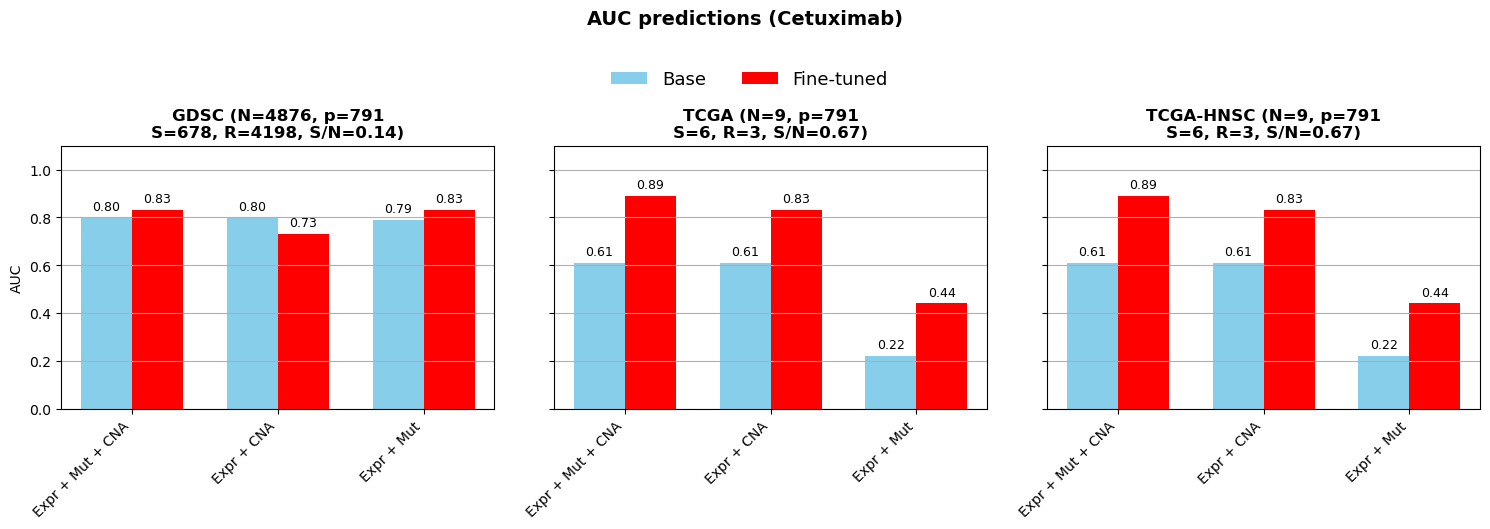

In [64]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Cetuximab)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (Cetuximab).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [65]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                                 f"AUCPR (TCGA, N={str(len(Ytscetuximab))})",
                                 f"AUCPR (TCGA-HNSC, N={str(len(Ytscetuximab_hnsc))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (TCGA, N={str(len(Ytscetuximab))})": f"TCGA (N={str(len(Ytscetuximab))}, p=" + str(TCGAEcetuximab.shape[1]) + "\nS=" + str(TCGARcetuximab["response"].value_counts()[1]) + ", R=" + str(TCGARcetuximab["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARcetuximab["response"].value_counts()[1]/sum(TCGARcetuximab["response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA-HNSC, N={str(len(Ytscetuximab_hnsc))})": f"TCGA-HNSC (N={str(len(Ytscetuximab_hnsc))}, p=" + str(TCGAEcetuximab.shape[1]) + "\nS=" + str(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]) + ", R=" + str(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]/sum(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=4876, p=791\nS=678, R=4198, S/N=0.14)","TCGA (N=9, p=791\nS=6, R=3, S/N=0.67)","TCGA-HNSC (N=9, p=791\nS=6, R=3, S/N=0.67)"
Data,,,
Expr + Mut + CNA,0.42,0.72,0.72
Expr + Mut + CNA (Fine-tuned),0.44,0.95,0.95
Expr + CNA,0.37,0.72,0.72
Expr + CNA (Fine-tuned),0.32,0.93,0.93
Expr + Mut,0.43,0.59,0.59
Expr + Mut (Fine-tuned),0.45,0.67,0.67


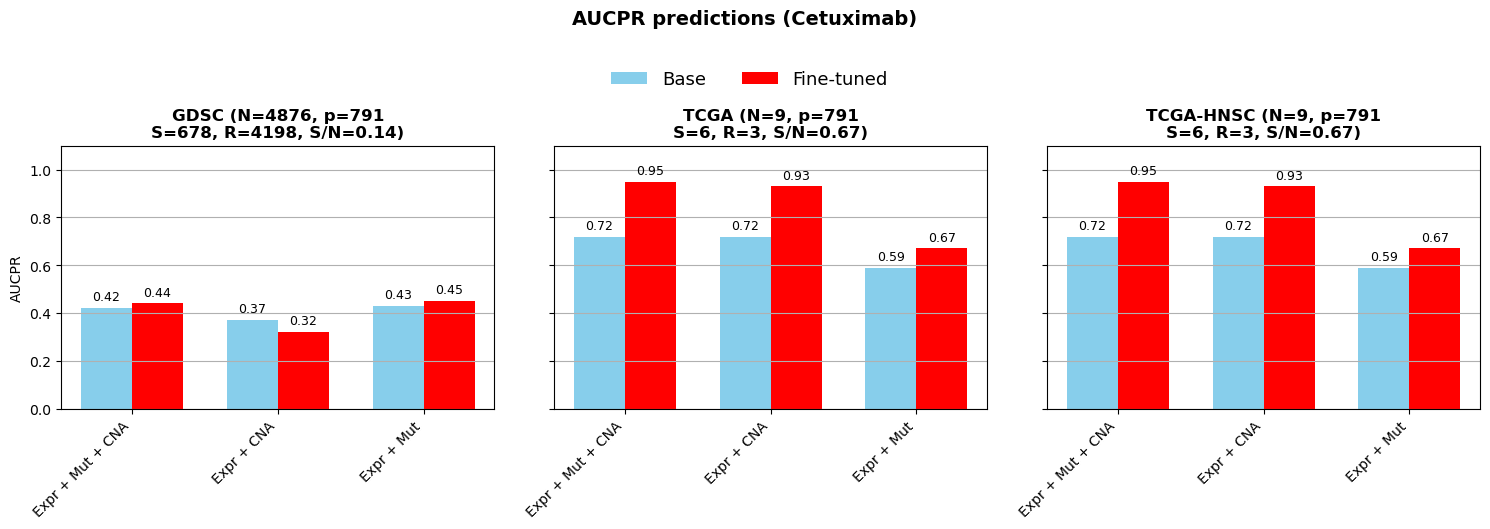

In [66]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Cetuximab)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Cetuximab).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [67]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_EGFRi/Expression_Mutation_CNA/Predictions


In [68]:
# save predictions

file = open('GDSC_TCGA_DEGs - TCGA_EGFRi_Cetuximab Predictions (Expression, Mutation, and CNA).txt', 'w')
file.write(f"GDSC Training (EMC) AUC (TCGA_EGFRi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EMC) AUCPR (TCGA_EGFRi): {round(AUCTaucpr,2)}\n\n")

file.write(f"TCGA Test (EMC) AUC (Cetuximab): {round(AUCTcetuximab,2)}\n")
file.write(f"TCGA Test (EMC) AUCPR (Cetuximab): {round(AUCTcetuximab_aucpr,2)}\n\n")

file.close()